In [27]:
import seaborn as sns
from scipy import stats
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
from ema_workbench import load_results
results = load_results(r'10k_scenarios.tar.gz')
experiments, outcomes = results
experiments.head()

[MainProcess/INFO] results loaded succesfully from D:\GitHub\likelihoodPRIM\10k_scenarios.tar.gz


,b,delta,mean,q,stdev,scenario,policy,model
0,0.147181,0.948084,0.042940,2.120977,0.004334,0,None,lakeproblem
1,0.125658,0.944953,0.034463,3.325194,0.004574,1,None,lakeproblem
2,0.256255,0.946291,0.010319,3.499250,0.003165,2,None,lakeproblem
3,0.214926,0.985462,0.020252,3.614743,0.002246,3,None,lakeproblem
4,0.230174,0.989367,0.038301,4.465881,0.004954,4,None,lakeproblem


C:\Users\jafino\Anaconda3\envs\Urban-SETP\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


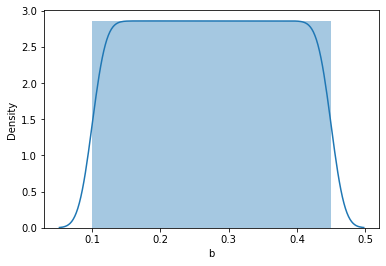

C:\Users\jafino\Anaconda3\envs\Urban-SETP\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


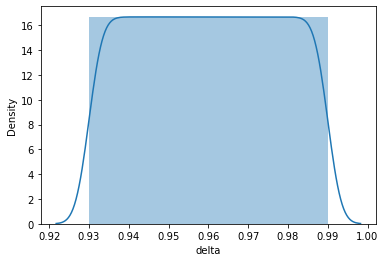

C:\Users\jafino\Anaconda3\envs\Urban-SETP\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


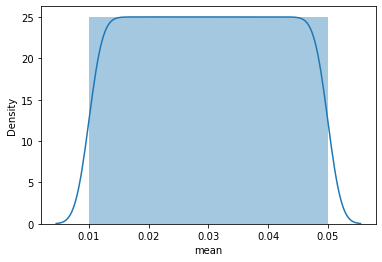

C:\Users\jafino\Anaconda3\envs\Urban-SETP\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


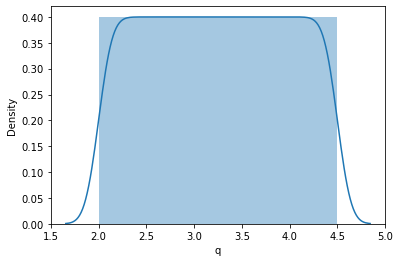

In [29]:
sns.distplot(experiments['b'])
plt.show()
sns.distplot(experiments['delta'])
plt.show()
sns.distplot(experiments['mean'])
plt.show()
sns.distplot(experiments['q'])
plt.show()

### Generate arbitrary relative likelihood for each uncertain variable

In [30]:
mu = 2
std = 1
x = 2
print(stats.norm.pdf(x, mu, std))
print(stats.norm.cdf(x, mu, std))

0.3989422804014327
0.5


In [31]:
mu_list = {'b': 0.2, 'delta': 0.97, 'mean': 0.03, 'q': 3}
std_list = {'b': 0.15, 'delta': 0.02, 'mean': 0.02, 'q': 0.9}

for var in ['b', 'delta', 'mean', 'q']:
    experiments[var+'_likelihood'] = stats.norm.pdf(experiments[var], mu_list[var], std_list[var])
    experiments[var+'_likelihood'] /= np.max(experiments[var+'_likelihood'])
    print(var, np.sum(experiments[var+'_likelihood']), np.max(experiments[var+'_likelihood']))

b 7516.84438374774 1.0
delta 6839.7068864983 1.0
mean 8556.244415680587 1.0
q 7390.083389766375 1.0


In [32]:
experiments['rel_prob'] = 1
for col in experiments.columns:
    if 'likelihood' in col:
        experiments['rel_prob'] *= experiments[col]
        
experiments['rel_prob'] = experiments['rel_prob'] / np.mean(experiments['rel_prob'])
np.sum(experiments['rel_prob']), len(experiments)

(10000.0, 10000)

### Now run both modified (dummy) PRIM and normal PRIM

In [33]:
from ema_workbench_l.analysis import prim_edited_dummy, prim
from ema_workbench_l import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Normal PRIM

In [34]:
x = experiments[['b', 'delta', 'mean', 'q']]
data = outcomes['reliability']
y = data < np.percentile(data, 15)

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 1500 cases of interest
[MainProcess/INFO] mean: 0.9920318725099602, mass: 0.0502, coverage: 0.332, density: 0.9920318725099602 restricted_dimensions: 3


PRIM with non-binary y

In [35]:
y_ = np.array(y.astype(int) * experiments['rel_prob'])

prim_alg = prim_edited_dummy.Prim(x, y_, threshold=0.2)
box2 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 1487 cases of interest
[MainProcess/INFO] mean: 1.6393289313700892, mass: 0.0502, coverage: 0.30867518493611296, density: 0.9143426294820717 restricted_dimensions: 4


### Compare coverage-density threshold

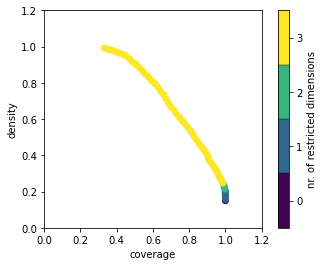

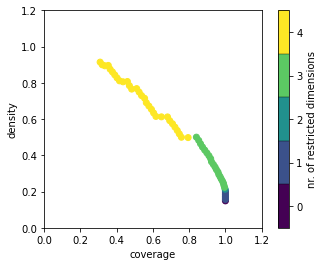

In [36]:
box1.show_tradeoff()
plt.show()
box2.show_tradeoff()
plt.show()

In [37]:
pt_1 = box1.peeling_trajectory
pt_2 = box2.peeling_trajectory
pt_1['box'] = 'box1_PRIM'
pt_2['box'] = 'box2_PRIM_likelihood'
box_combined = pt_1.append(pt_2)

(0.1, 1.02)

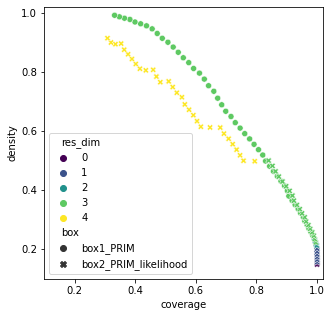

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='coverage', y='density', hue='res_dim', data=box_combined, style='box', palette='viridis', ax=ax)
ax.set_ylim(0.1,1.02)
ax.set_xlim(0.1,1.02)

### Does the standard PRIM adequately capture relative likelihood information? To investigate this, we compare weighted density and coverage from each box from the normal PRIM run

In [39]:
experiments['y'] = y
total_coi = experiments.loc[experiments['y'], 'rel_prob'].sum()

In [40]:
box1.peeling_trajectory['weighted_coverage'] = 0
box1.peeling_trajectory['weighted_density'] = 0

for i in range(len(box1.box_lims)):
    if i > 0:
        all_vars = list(box1.qp[i])
        experiments_ = experiments.copy()
        for var in all_vars:
            upper_lim = box1.box_lims[i][var][1]
            lower_lim = box1.box_lims[i][var][0]
            experiments_ = experiments.loc[(experiments[var]>lower_lim) & (experiments[var]<upper_lim)]
            
        #calculate weighted coverage
        coi_in_box = experiments_.loc[experiments_['y'], 'rel_prob'].sum()
        weighted_coverage = coi_in_box / total_coi
        
        #calculate weighted density
        total_cases_in_box = experiments_['rel_prob'].sum()
        weighted_density = coi_in_box / total_cases_in_box
        
        box1.peeling_trajectory.loc[i, 'weighted_coverage'] = weighted_coverage
        box1.peeling_trajectory.loc[i, 'weighted_density'] = weighted_density

In [41]:
box_to_show1 = pd.DataFrame()
box_to_show1['coverage'] = box1.peeling_trajectory['coverage']
box_to_show1['density'] = box1.peeling_trajectory['density']
box_to_show1['PRIM'] = 'Original'

box_to_show2 = pd.DataFrame()
box_to_show2['coverage'] = box1.peeling_trajectory['weighted_coverage']
box_to_show2['density'] = box1.peeling_trajectory['weighted_density']
box_to_show2['PRIM'] = 'Likelihood'

box_to_show = box_to_show1.append(box_to_show2).reset_index()

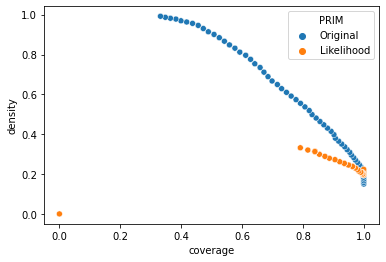

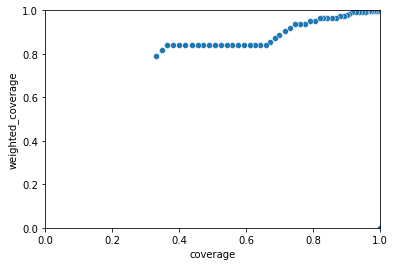

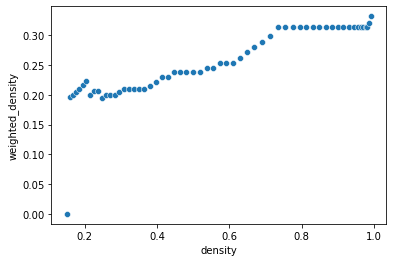

In [42]:
sns.scatterplot(x='coverage', y='density', data=box_to_show, hue='PRIM')
plt.show()
ax = sns.scatterplot(x='coverage', y='weighted_coverage', data=box1.peeling_trajectory)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()
sns.scatterplot(x='density', y='weighted_density', data=box1.peeling_trajectory)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

In [43]:
box1.peeling_trajectory.tail()

,coverage,density,id,mass,mean,res_dim,box,weighted_coverage,weighted_density
54,0.399333,0.969256,54,0.0618,0.969256,3,box1_PRIM,0.839385,0.313014
55,0.382667,0.977853,55,0.0587,0.977853,3,box1_PRIM,0.839385,0.313014
56,0.364667,0.982047,56,0.0557,0.982047,3,box1_PRIM,0.839385,0.313014
57,0.348000,0.986767,57,0.0529,0.986767,3,box1_PRIM,0.816174,0.320520
58,0.332000,0.992032,58,0.0502,0.992032,3,box1_PRIM,0.791507,0.331888


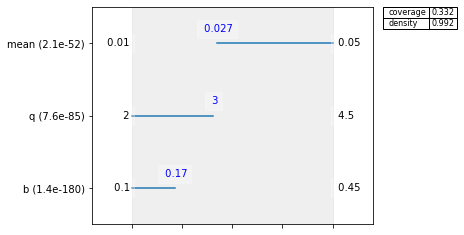

In [44]:
box1.inspect(58, style='graph')
plt.show()

### Check boxes with comparable density and coverage

In [118]:
data = outcomes['max_P']
y = data > np.percentile(data, 80)
# y = data < np.percentile(data, 20)
experiments['y'] = y
print(experiments['y'].sum())

2000


In [119]:
#standard PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

#weighted PRIM
y_ = np.array(y.astype(int) * experiments['rel_prob'])
prim_alg = prim_edited_dummy.Prim(x, y_, threshold=0.2)
box2 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0557, coverage: 0.2785, density: 1.0 restricted_dimensions: 3
[MainProcess/INFO] 10000 points remaining, containing 1979 cases of interest
[MainProcess/INFO] mean: 1.8829609491558152, mass: 0.0502, coverage: 0.23749368367862556, density: 0.9362549800796812 restricted_dimensions: 4


In [120]:
box1.peeling_trajectory.iloc[32], box2.peeling_trajectory.iloc[30]

(coverage       0.722
 density     0.747799
 id                32
 mass          0.1931
 mean        0.747799
 res_dim            3
 Name: 32, dtype: object,
 coverage    0.725619
 density     0.671028
 id                30
 mass           0.214
 mean        1.037608
 res_dim            4
 Name: 30, dtype: object)

In [121]:
box1.box_lims[32]

,b,delta,mean,q
0,0.100012,0.930000,0.020412,2.000021
1,0.247237,0.989999,0.049996,3.568389


In [122]:
box2.box_lims[30]

,b,delta,mean,q
0,0.100012,0.935664,0.017380,2.000021
1,0.254219,0.989999,0.049996,3.641972


In [123]:
labels = ['Low','Medium','High','Highest']
experiments['likelihood_cat'] = pd.qcut(experiments['rel_prob'], q=[0., 0.25, 0.5, 0.75, 1.], labels=labels)

<AxesSubplot:xlabel='q', ylabel='b'>

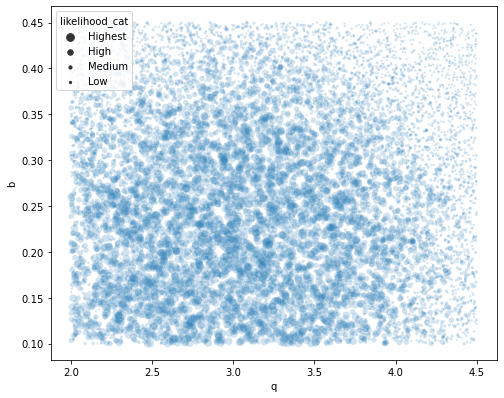

In [124]:
fig, ax = plt.subplots(figsize=(8,6.5))
sns.scatterplot(x='q', y='b', data=experiments, size='likelihood_cat', alpha=0.2, ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5])

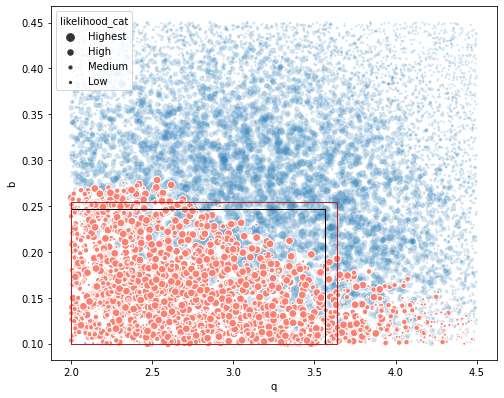

In [125]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,6.5))
sns.scatterplot(x='q', y='b', data=experiments.loc[~experiments['y']], size='likelihood_cat', alpha=0.2, ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5])
sns.scatterplot(x='q', y='b', data=experiments.loc[experiments['y']], size='likelihood_cat', color='salmon', ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5], legend=False, linewidth=1)

#add box
box1_lim = box1.box_lims[32]
box2_lim = box2.box_lims[30]
currentAxis = plt.gca()

currentAxis.add_patch(Rectangle((box1_lim.loc[0, 'q'], box1_lim.loc[0, 'b']), 
                                box1_lim.loc[1, 'q'] - box1_lim.loc[0, 'q'], box1_lim.loc[1, 'b'] - box1_lim.loc[0, 'b'],
                                alpha=1, facecolor='none', lw=1, edgecolor='black'))

currentAxis.add_patch(Rectangle((box2_lim.loc[0, 'q'], box2_lim.loc[0, 'b']), 
                                box2_lim.loc[1, 'q'] - box2_lim.loc[0, 'q'], box2_lim.loc[1, 'b'] - box2_lim.loc[0, 'b'],
                                alpha=1, facecolor='none', lw=1, edgecolor='firebrick'))

### Check another one

In [112]:
data = outcomes['max_P']
# y = data > np.percentile(data, 80)
y = data < np.percentile(data, 20)
experiments['y'] = y
print(experiments['y'].sum())

2000


In [113]:
#standard PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

#weighted PRIM
y_ = np.array(y.astype(int) * experiments['rel_prob'])
prim_alg = prim_edited_dummy.Prim(x, y_, threshold=0.2)
box2 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0891, coverage: 0.4455, density: 1.0 restricted_dimensions: 3
[MainProcess/INFO] 10000 points remaining, containing 1766 cases of interest
[MainProcess/INFO] mean: 1.0820993445019458, mass: 0.0502, coverage: 0.23952434881087203, density: 0.8426294820717132 restricted_dimensions: 4


In [114]:
box1.peeling_trajectory.iloc[30], box2.peeling_trajectory.iloc[30]

(coverage      0.8395
 density     0.784579
 id                30
 mass           0.214
 mean        0.784579
 res_dim            2
 Name: 30, dtype: object,
 coverage     0.81427
 density     0.671963
 id                30
 mass           0.214
 mean        0.568615
 res_dim            3
 Name: 30, dtype: object)

In [106]:
box1.box_lims[30]

,b,delta,mean,q
0,0.240807,0.930000,0.010001,2.000021
1,0.449984,0.989999,0.024190,4.499838


In [107]:
box2.box_lims[30]

,b,delta,mean,q
0,0.179058,0.941749,0.010001,2.000021
1,0.449984,0.989999,0.023583,4.499838


In [108]:
labels = ['Low','Medium','High','Highest']
experiments['likelihood_cat'] = pd.qcut(experiments['rel_prob'], q=[0., 0.25, 0.5, 0.75, 1.], labels=labels)

<AxesSubplot:xlabel='q', ylabel='b'>

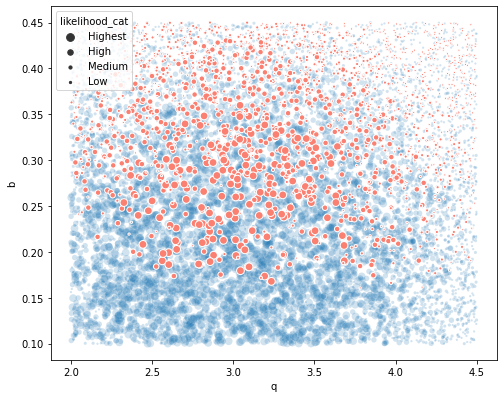

In [109]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,6.5))
sns.scatterplot(x='q', y='b', data=experiments.loc[~experiments['y']], size='likelihood_cat', alpha=0.2, ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5])
sns.scatterplot(x='q', y='b', data=experiments.loc[experiments['y']], size='likelihood_cat', color='salmon', ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5], legend=False, linewidth=1)

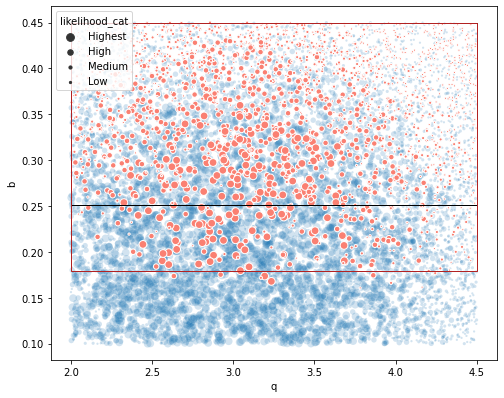

In [116]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,6.5))
sns.scatterplot(x='q', y='b', data=experiments.loc[~experiments['y']], size='likelihood_cat', alpha=0.2, ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5])
sns.scatterplot(x='q', y='b', data=experiments.loc[experiments['y']], size='likelihood_cat', color='salmon', ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5], legend=False, linewidth=1)

#add box
box1_lim = box1.box_lims[32]
box2_lim = box2.box_lims[30]
currentAxis = plt.gca()

currentAxis.add_patch(Rectangle((box1_lim.loc[0, 'q'], box1_lim.loc[0, 'b']), 
                                box1_lim.loc[1, 'q'] - box1_lim.loc[0, 'q'], box1_lim.loc[1, 'b'] - box1_lim.loc[0, 'b'],
                                alpha=1, facecolor='none', lw=1, edgecolor='black'))

currentAxis.add_patch(Rectangle((box2_lim.loc[0, 'q'], box2_lim.loc[0, 'b']), 
                                box2_lim.loc[1, 'q'] - box2_lim.loc[0, 'q'], box2_lim.loc[1, 'b'] - box2_lim.loc[0, 'b'],
                                alpha=1, facecolor='none', lw=1, edgecolor='firebrick'))